In [1]:
import boto3
import io
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

#import awswrangler as wr
#import s3fs
#from fastparquet import write

import joblib

#modeling
import statsmodels.api as sm
from statsmodels.api import add_constant
from sklearn import preprocessing
from sklearn.model_selection import train_test_split,ShuffleSplit, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import roc_curve, auc, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay,\
classification_report, accuracy_score, f1_score, precision_recall_curve
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt
import sklearn.metrics as metrics
from sklearn.metrics import make_scorer, roc_auc_score, log_loss, brier_score_loss
from sklearn.utils import resample


import lightgbm as lgbm

plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings("ignore")

### Data Load

In [2]:
df =  pd.read_parquet('model_ready.parquet')

In [3]:
df.shape

(4375069, 230)

In [4]:
# #remove duplciate columns
# df = df.T.drop_duplicates().T
# print(df.shape)

In [5]:
# df['pfmc_cur_month'].unique()

array(['2022-01', '2022-02', '2022-03', '2022-04', '2022-05', '2022-06'],
      dtype=object)

In [19]:
#### out-date
out_date = '2022-06'

In [ ]:
### additional features

In [6]:
df['rest_mpt'] = df['mpt_10']+df['mpt_600']+df['mpt_620']+df['mpt_1600']+df['mpt_20881']

In [4]:
df['rdr_face_amt'] = df['rdr1_face_amt']+df['rdr2_face_amt']+df['rdr3_face_amt']

In [5]:
df['retain_trgt_7'] = df['rtain_amt']-df['trgt_7_pay']

In [7]:
df['policy_age_sq']=df['policy_age']*df['policy_age']

In [8]:
df['holder_age_cash']=df['holder_age']*df['mod_mpt_total']

In [35]:
df['policy_age_trgt7']=df['policy_age']*df['trgt_7_pay']

In [36]:
df['policy_age_diff_aum']=df['policy_age']*df['diff_aum_cash_val']

In [37]:
df['holder_age_cash']=df['holder_age']*df['mod_mpt_total']

In [38]:
df['issue_age_cash']=df['issue_age']*df['mod_mpt_total']

In [39]:
df['diff_cash_holder_issue']=df['holder_age_cash']-df['issue_age_cash']

### Performance Metrics

In [29]:
#roc curve
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

In [27]:
def fn_importance_features(model):
    clf = model
    feature_importances_data = []
    features = train_X.columns
    for feature_name, feature_importance in zip(features, clf.feature_importances_):
        feature_importances_data.append({
            'feature': feature_name,
            'importance': feature_importance
        })

    # Plot the results
    pd.DataFrame(feature_importances_data)\
        .set_index('feature')\
        .sort_values(by='importance')[-30::]\
        .plot(title='Top 20 most important features: '+ str(type(model).__name__),
              kind='barh',figsize=(10, 6),
              color='#348ABD',alpha=0.6,
              lw='1', edgecolor='#348ABD',grid=False,)

In [28]:
#key performance metrics
def fn_metrics(act, prob, pred):
    #ROC
    fpr, tpr, thresholds = roc_curve(act, prob)
    roc_auc = auc(fpr, tpr)
    plot_roc_curve(fpr, tpr)
    
    print ('ROC value of:{:.2f}'.format(roc_auc*100))
    print ('Accuracy:{:.2f}'.format(accuracy_score(act, pred)*100))
    print ('F1 score:{:.2f}'.format(f1_score(act, pred)*100))
    print ('Recall:{:.2f}'.format(recall_score(act, pred)*100))
    print ('Precision:{:.2f}'.format(precision_score(act, pred)*100))
    print ('\n clasification report:\n',classification_report(act, pred))
     
    #plot confusion matrix    
    fig, ax = plt.subplots(1,1,figsize=(8,6))
    plt.rcParams.update({'font.size': 16})
    ConfusionMatrixDisplay(confusion_matrix(pred, act, labels=[1,0]), 
                       display_labels=['3mo_ahead_lapse','No_Lapse']).plot(values_format=".0f",ax=ax)

    ax.set_xlabel("Actual Label")
    ax.set_ylabel("Predicted Label")
    plt.show()

In [14]:
# df_dtypes = df.dtypes.to_frame('dtypes').reset_index().rename(columns = {"index":"Columns"})
# df_missing = pd.DataFrame(df.isnull().sum()/len(df)).reset_index().rename(columns = {"index":"Columns", 0:"Missing%"})
# df_unique =pd.DataFrame(df.nunique()).reset_index().rename(columns = {"index":"Columns", 0:"# of Unique Values"})
# df_summary = df_dtypes.merge(df_missing, on='Columns', how='inner').merge(df_unique, on='Columns', how='inner')
# df_summary.out = df_summary.to_csv("df_summary.csv",  header=True)
# df_summary

,Columns,dtypes,Missing%,# of Unique Values
0,month,int64,0.000000e+00,6
1,agmt_pkge_id,object,0.000000e+00,736008
2,aos_status_code,object,0.000000e+00,12
3,val_inforce_cls,object,0.000000e+00,4
4,kind_code,object,0.000000e+00,99
5,sub_kind,object,0.000000e+00,3
6,conv_undrwrt_code,object,8.261606e-01,2
7,conv_type,object,8.259245e-01,6
8,spec_id,int64,0.000000e+00,166
9,premium_basis,int64,0.000000e+00,7


### Features

In [47]:
features =[
#target
'3mo_ahead_Lapse',
'pfmc_cur_month',

#categorical
'current_status',
'holder_age_bucket',
'cash_val_bucket',
'issue_yr_cohort',
'gndr_cd',
'prem_mode',
'val_inforce_cls',
'lob_group',
'prod_grp',
'mrtl_stat_cd',
'place_abbrev',
'rtl_dstrb_orphn_cd',
'aos_status_code',
'smoking_habit',
'conv_type',
'premium_basis',
'tax_basis',
'div_option',
'spec_und_code',
'medical_issue_cd',
'pension_code',
'pgls_product_code',
'int_loan_typ_cd',
'abbr_pay_typ_cd',
'opr_stat_cd',
'pln_id',
'prem_pattern_cd',
'pref_lang_cd',
'ny_state_specific',
'SR_TYPE_CATG',
'surrender_ind_lag1',
'reinstate_ind_lag1',
'lapse_ind_lag1',
'surrender_ind_lag2',
'reinstate_ind_lag2',
'lapse_ind_lag2',
'ixi_buoyancy',
'ixi_fin_cohort_cd',
'closed',           
           
#numerical   
'mod_mpt3',
'mod_mpt4',
'rest_mpt',
'rdr_face_amt',
'mod_mpt_total',
'base_face_amt',

'rtain_amt',
'ceded_amt',
'net_rsk_amt',
'trgt_7_pay',
'retain_trgt_7',
    
'tot_loan_prncpl',
'tot_loan_fnd_val',
    
'mod_bld_payment',
'mod_sch_payment',

'mpt3_bld_face_amt',
'mpt3_sch_face_amt',
'mpt_total_bld_face_amt',
'mpt_total_sch_face_amt',
'mpt4_bld_face_amt',
'mpt4_sch_face_amt',


'diff_mod_bld_value',
'diff_mod_sch_value',
    

'issue_age',
'holder_age',
'policy_age',
'policy_age_sq',

'policy_age_cash',
'holder_age_cash',
'issue_age_cash',
'policy_age_trgt7',
'policy_age_diff_aum',
'diff_cash_holder_issue',
    
'num_lapse_3m',
'num_reinstate_3m',
'num_current_3m',
    
'loan_rate',
    
'diff_act_pmt_target_pmt_3',
'diff_act_pmt_target_pmt_2',
'diff_act_pmt_target_pmt_1',
'diff_aum_cash_val',

'annlzd_bld_prem',
'accum_actual_prem_paid',
'accum_actual_prem_paid_lag3',
'accum_actual_prem_paid_lag3_change',

'modal_prem_bld',
'modal_prem_bld_lag3',
'modal_prem_bld_lag3_change',
'prem_mode_change_flag',
    
'num_sr_catg',
'max_sr_time'

]

In [48]:
ml_dataset =df[features]
ml_dataset.shape

(4375069, 92)

In [49]:
# fill na
ml_dataset= ml_dataset.fillna(0)

### Preprocessing: Categorical

In [50]:
%%time
cat_features = [
'current_status',
'holder_age_bucket',
'cash_val_bucket',
'issue_yr_cohort',
'gndr_cd',
'prem_mode',
'val_inforce_cls',
'lob_group',
'prod_grp',
'mrtl_stat_cd',
'place_abbrev',
'rtl_dstrb_orphn_cd',
'aos_status_code',
'smoking_habit',
'conv_type',
'premium_basis',
'tax_basis',
'div_option',
'spec_und_code',
'medical_issue_cd',
'pension_code',
'pgls_product_code',
'int_loan_typ_cd',
'abbr_pay_typ_cd',
'opr_stat_cd',
'pln_id',
'prem_pattern_cd',
'pref_lang_cd',
'ny_state_specific',
'SR_TYPE_CATG',
'surrender_ind_lag1',
'reinstate_ind_lag1',
'lapse_ind_lag1',
'surrender_ind_lag2',
'reinstate_ind_lag2',
'lapse_ind_lag2',
'ixi_buoyancy',
'ixi_fin_cohort_cd',
'closed'
]   

for f in ml_dataset[cat_features]:
    print(f)
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(ml_dataset[f].values))
    ml_dataset[f] = lbl.transform(list(ml_dataset[f].values))

current_status
holder_age_bucket
cash_val_bucket
issue_yr_cohort
gndr_cd
prem_mode
val_inforce_cls
lob_group
prod_grp
mrtl_stat_cd
place_abbrev
rtl_dstrb_orphn_cd
aos_status_code
smoking_habit
conv_type
premium_basis
tax_basis
div_option
spec_und_code
medical_issue_cd
pension_code
pgls_product_code
int_loan_typ_cd
abbr_pay_typ_cd
opr_stat_cd
pln_id
prem_pattern_cd
pref_lang_cd
ny_state_specific
SR_TYPE_CATG
surrender_ind_lag1
reinstate_ind_lag1
lapse_ind_lag1
surrender_ind_lag2
reinstate_ind_lag2
lapse_ind_lag2
ixi_buoyancy
ixi_fin_cohort_cd
closed
CPU times: total: 1min 29s
Wall time: 1min 29s


### Preprocessing: Numerical 

In [51]:
%%time
num_features = [
'mod_mpt3',
'mod_mpt4',
'rest_mpt',
'rdr_face_amt',
'mod_mpt_total',
    
'base_face_amt',
'rtain_amt',
'ceded_amt',
'net_rsk_amt',
'trgt_7_pay',
'retain_trgt_7',
    
'tot_loan_prncpl',
'tot_loan_fnd_val',
    
'mod_bld_payment',
'mod_sch_payment',

'mpt3_bld_face_amt',
'mpt3_sch_face_amt',
'mpt_total_bld_face_amt',
'mpt_total_sch_face_amt',
'mpt4_bld_face_amt',
'mpt4_sch_face_amt',


'diff_mod_bld_value',
'diff_mod_sch_value',
    

'issue_age',
'holder_age',
'policy_age',
'policy_age_sq',

'policy_age_cash',
'holder_age_cash',
'issue_age_cash',
'policy_age_trgt7',
'policy_age_diff_aum',
'diff_cash_holder_issue',
    
'num_lapse_3m',
'num_reinstate_3m',
'num_current_3m',
    
'loan_rate',
    
'diff_act_pmt_target_pmt_3',
'diff_act_pmt_target_pmt_2',
'diff_act_pmt_target_pmt_1',
'diff_aum_cash_val',

'annlzd_bld_prem',
'accum_actual_prem_paid',
'accum_actual_prem_paid_lag3',
'accum_actual_prem_paid_lag3_change',

'modal_prem_bld',
'modal_prem_bld_lag3',
'modal_prem_bld_lag3_change',
'prem_mode_change_flag',
    
'num_sr_catg',
'max_sr_time']

for f in ml_dataset[num_features] :
    print(f)
    _min = ml_dataset[f].min()
    _max = ml_dataset[f].max()
    scale = _max - _min
    shift = _min
    ml_dataset[f] = (ml_dataset[f] - shift).astype(np.float64) / scale

mod_mpt3
mod_mpt4
rest_mpt
rdr_face_amt
mod_mpt_total
base_face_amt
rtain_amt
ceded_amt
net_rsk_amt
trgt_7_pay
retain_trgt_7
tot_loan_prncpl
tot_loan_fnd_val
mod_bld_payment
mod_sch_payment
mpt3_bld_face_amt
mpt3_sch_face_amt
mpt_total_bld_face_amt
mpt_total_sch_face_amt
mpt4_bld_face_amt
mpt4_sch_face_amt
diff_mod_bld_value
diff_mod_sch_value
issue_age
holder_age
policy_age
policy_age_sq
policy_age_cash
holder_age_cash
issue_age_cash
policy_age_trgt7
policy_age_diff_aum
diff_cash_holder_issue
num_lapse_3m
num_reinstate_3m
num_current_3m
loan_rate
diff_act_pmt_target_pmt_3
diff_act_pmt_target_pmt_2
diff_act_pmt_target_pmt_1
diff_aum_cash_val
annlzd_bld_prem
accum_actual_prem_paid
accum_actual_prem_paid_lag3
accum_actual_prem_paid_lag3_change
modal_prem_bld
modal_prem_bld_lag3
modal_prem_bld_lag3_change
prem_mode_change_flag
num_sr_catg
max_sr_time
CPU times: total: 14.6 s
Wall time: 14.6 s


### Create a Target

In [52]:
ml_dataset['__target__'] = ml_dataset['3mo_ahead_Lapse']
del ml_dataset['3mo_ahead_Lapse']

# Remove rows for which the target is unknown.
#ml_dataset = ml_dataset[~ml_dataset['__target__'].isnull()]

### Split Train/Validation/Test

In [53]:
# Train data < outdate
train = ml_dataset[ml_dataset['pfmc_cur_month'] < out_date]

# split train to train and  test (validation) data
train, valid = train_test_split(train, test_size=0.05, random_state=101)

# test data >= outdate
test = ml_dataset[ml_dataset['pfmc_cur_month'] >= out_date]

train = train.drop(columns=['pfmc_cur_month'])
valid = valid.drop(columns=['pfmc_cur_month'])
test = test.drop(columns=['pfmc_cur_month'])

#train, test = train_test_split(ml_dataset, test_size=0.2, random_state=101)
print ('Train data has %i rows and %i columns' % (train.shape[0], train.shape[1]))
print ('Valiation data has %i rows and %i columns' % (valid.shape[0], valid.shape[1]))
print ('Test data has %i rows and %i columns' % (test.shape[0], test.shape[1]))

Train data has 3462831 rows and 91 columns
Valiation data has 182255 rows and 91 columns
Test data has 729983 rows and 91 columns


In [54]:
train_X = train.drop('__target__', axis=1)
valid_X = valid.drop('__target__', axis=1)
test_X = test.drop('__target__', axis=1)

train_Y = np.array(train['__target__'])
valid_Y = np.array(valid['__target__'])
test_Y = np.array(test['__target__'])

### LGBM Model

In [55]:
from lightgbm import LGBMClassifier
from optuna.samplers import TPESampler
from optuna.pruners import SuccessiveHalvingPruner
import optuna
from optuna.samplers import TPESampler
from optuna import Trial
from sklearn.model_selection import KFold

In [57]:
def accuracy(true, pred):
    return np.mean(true==pred)

def objective(trial):
    
    params = {
        'objective': 'binary', 
        'learning_rate': trial.suggest_float('learning_rate', 0.0001, 0.1, log=True), 
        'num_leaves': trial.suggest_int('num_leaves', 2, 300), 
        'max_depth': trial.suggest_int('max_depth', 1, 200), 
        'n_estimators': trial.suggest_int('n_estimators', 10, 200), 
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 500), 
        'subsample': trial.suggest_uniform('subsample', 0.7, 1.0), 
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.3, 1.0),
        'reg_alpha': trial.suggest_uniform('reg_alpha', 0.0, 100.0),
        'reg_lambda': trial.suggest_uniform('reg_lambda', 0.0, 100.0),
        'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 0.0, 70.0),
        'min_split_gain': trial.suggest_uniform('min_split_gain', 0.0, 1.0),
        'random_state': 101
    }
    
    #scoring = { 'AUC': 'roc_auc',  'Log_loss': 'neg_log_loss', 'F1': 'f1','Recall': 'recall', 'Precision': 'precision'} 
    #score=[]
    clf = LGBMClassifier(**params)
    clf.fit(train_X, train_Y, eval_set = [(valid_X, valid_Y)], 
                              eval_metric =  'neg_log_loss',
                              early_stopping_rounds = 50, verbose=50)
        
    #predicts
    pred = clf.predict(test_X)
    probs = clf.predict_proba(test_X)
    
    #metrics
    #acc = metrics.accuracy_score(pred, test_Y)
    recall = metrics.recall_score(pred, test_Y)
    precision = metrics.precision_score(pred, test_Y)
    f1 = metrics.f1_score(pred, test_Y)
    
#     pred = clf.predict(test_X)
#     true = test_Y
#     score.append(precision(true, pred))
#     score = np.mean(score)
    return f1, recall, precision

### optuna tuning

In [63]:
study = optuna.create_study(directions=[ 'maximize', 'maximize', 'maximize'])
study.optimize(objective, n_trials=100)

[I 2022-12-06 14:02:33,483] A new study created in memory with name: no-name-7c611334-5799-4349-920b-b6548951ee3e


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0654402
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.0176483


[I 2022-12-06 14:02:48,561] Trial 0 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.015174145025721047, 'num_leaves': 265, 'max_depth': 115, 'n_estimators': 92, 'min_child_samples': 47, 'subsample': 0.9283877450110768, 'colsample_bytree': 0.349787213476763, 'reg_alpha': 71.6031709799856, 'reg_lambda': 51.270728385062235, 'scale_pos_weight': 62.13797705206014, 'min_split_gain': 0.3347433655027098}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0166071
Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.0165642


[I 2022-12-06 14:03:13,553] Trial 1 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.00046073682222228966, 'num_leaves': 136, 'max_depth': 120, 'n_estimators': 166, 'min_child_samples': 124, 'subsample': 0.8979776568228439, 'colsample_bytree': 0.8106358048797755, 'reg_alpha': 95.3166992619909, 'reg_lambda': 9.495054658845536, 'scale_pos_weight': 41.226885398307566, 'min_split_gain': 0.2416532376045415}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0173772
Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.016706


[I 2022-12-06 14:03:34,955] Trial 2 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.0007888895854076504, 'num_leaves': 273, 'max_depth': 183, 'n_estimators': 130, 'min_child_samples': 187, 'subsample': 0.7886942304004728, 'colsample_bytree': 0.49909788128336346, 'reg_alpha': 37.4957290915632, 'reg_lambda': 24.940546621455915, 'scale_pos_weight': 50.0313255238108, 'min_split_gain': 0.6765576220879419}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0173494
Early stopping, best iteration is:
[15]	valid_0's binary_logloss: 0.0169205


[I 2022-12-06 14:03:45,484] Trial 3 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.0004562715940450266, 'num_leaves': 5, 'max_depth': 67, 'n_estimators': 187, 'min_child_samples': 169, 'subsample': 0.8511994153484714, 'colsample_bytree': 0.617027664382797, 'reg_alpha': 21.623217089518988, 'reg_lambda': 51.11347063593905, 'scale_pos_weight': 58.709831568080425, 'min_split_gain': 0.9888578777585876}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0220329
Early stopping, best iteration is:
[5]	valid_0's binary_logloss: 0.0167107


[I 2022-12-06 14:04:00,075] Trial 4 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.0027590230429591195, 'num_leaves': 154, 'max_depth': 119, 'n_estimators': 74, 'min_child_samples': 203, 'subsample': 0.7363778095750926, 'colsample_bytree': 0.9028025392033239, 'reg_alpha': 72.76381266584401, 'reg_lambda': 48.567701586802315, 'scale_pos_weight': 44.82675724385305, 'min_split_gain': 0.8448522670630116}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0733039
Early stopping, best iteration is:
[3]	valid_0's binary_logloss: 0.0481043


[I 2022-12-06 14:04:16,151] Trial 5 finished with values: [0.046218487394957986, 0.028284906145538698, 0.12629161882893225] and parameters: {'learning_rate': 0.0418540452136725, 'num_leaves': 112, 'max_depth': 195, 'n_estimators': 150, 'min_child_samples': 378, 'subsample': 0.7975145699619184, 'colsample_bytree': 0.8320295075861632, 'reg_alpha': 29.759239122647475, 'reg_lambda': 12.806112125079583, 'scale_pos_weight': 38.61667515769054, 'min_split_gain': 0.5029433951961936}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0165469
Did not meet early stopping. Best iteration is:
[75]	valid_0's binary_logloss: 0.0165018


[I 2022-12-06 14:04:41,717] Trial 6 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.0002862414446908879, 'num_leaves': 143, 'max_depth': 46, 'n_estimators': 94, 'min_child_samples': 52, 'subsample': 0.8727075981723523, 'colsample_bytree': 0.8436899653855552, 'reg_alpha': 64.46304890478578, 'reg_lambda': 7.395468069901501, 'scale_pos_weight': 31.40981447056745, 'min_split_gain': 0.9362638400537133}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0167266
Early stopping, best iteration is:
[26]	valid_0's binary_logloss: 0.0165983


[I 2022-12-06 14:05:01,899] Trial 7 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.0017765797170450092, 'num_leaves': 274, 'max_depth': 21, 'n_estimators': 100, 'min_child_samples': 250, 'subsample': 0.9383474923739579, 'colsample_bytree': 0.8051180681311843, 'reg_alpha': 68.21642136317926, 'reg_lambda': 45.179992961881496, 'scale_pos_weight': 12.931740549525795, 'min_split_gain': 0.58327044386521}. 


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's binary_logloss: 0.0176939


[I 2022-12-06 14:05:11,924] Trial 8 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.02089184183146732, 'num_leaves': 37, 'max_depth': 185, 'n_estimators': 23, 'min_child_samples': 296, 'subsample': 0.8215856858081078, 'colsample_bytree': 0.7552002296759226, 'reg_alpha': 63.08832974683958, 'reg_lambda': 42.969295348634226, 'scale_pos_weight': 43.68321915900804, 'min_split_gain': 0.051232803479914324}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0214767
Early stopping, best iteration is:
[5]	valid_0's binary_logloss: 0.0166418


[I 2022-12-06 14:05:28,453] Trial 9 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.009947964943917444, 'num_leaves': 261, 'max_depth': 199, 'n_estimators': 68, 'min_child_samples': 241, 'subsample': 0.9037610716251396, 'colsample_bytree': 0.6794738586212409, 'reg_alpha': 1.7340300131817754, 'reg_lambda': 64.06181255340654, 'scale_pos_weight': 13.577348806283261, 'min_split_gain': 0.6668711405010125}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0188965
Early stopping, best iteration is:
[5]	valid_0's binary_logloss: 0.0164535


[I 2022-12-06 14:05:44,431] Trial 10 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.023124841786627146, 'num_leaves': 143, 'max_depth': 157, 'n_estimators': 76, 'min_child_samples': 36, 'subsample': 0.8321207771578071, 'colsample_bytree': 0.6880347934298469, 'reg_alpha': 77.27976106865323, 'reg_lambda': 29.406836571078742, 'scale_pos_weight': 5.401169189269705, 'min_split_gain': 0.25320227329030154}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0174169
Early stopping, best iteration is:
[14]	valid_0's binary_logloss: 0.0169016


[I 2022-12-06 14:05:54,408] Trial 11 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.0006308213923097184, 'num_leaves': 282, 'max_depth': 2, 'n_estimators': 105, 'min_child_samples': 122, 'subsample': 0.94830347072975, 'colsample_bytree': 0.7679771523451913, 'reg_alpha': 50.01221351401654, 'reg_lambda': 30.0363532048041, 'scale_pos_weight': 43.30387178955639, 'min_split_gain': 0.49040978522516643}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0170912
[100]	valid_0's binary_logloss: 0.017087
[150]	valid_0's binary_logloss: 0.017083
Did not meet early stopping. Best iteration is:
[171]	valid_0's binary_logloss: 0.0170814


[I 2022-12-06 14:06:12,562] Trial 12 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.00024880861433531883, 'num_leaves': 287, 'max_depth': 17, 'n_estimators': 171, 'min_child_samples': 112, 'subsample': 0.9736877456435882, 'colsample_bytree': 0.7295853494481992, 'reg_alpha': 69.73146559720436, 'reg_lambda': 6.552950549724801, 'scale_pos_weight': 0.25210492472230617, 'min_split_gain': 0.25038341875177117}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0169542
Early stopping, best iteration is:
[26]	valid_0's binary_logloss: 0.0168111


[I 2022-12-06 14:06:31,859] Trial 13 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.0006686165734124085, 'num_leaves': 236, 'max_depth': 111, 'n_estimators': 91, 'min_child_samples': 435, 'subsample': 0.7491363421531261, 'colsample_bytree': 0.546934624038899, 'reg_alpha': 69.96818291580036, 'reg_lambda': 97.81498264922631, 'scale_pos_weight': 31.990904466355417, 'min_split_gain': 0.4463461299151952}. 


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[14]	valid_0's binary_logloss: 0.016579


[I 2022-12-06 14:06:47,030] Trial 14 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.001018941787178034, 'num_leaves': 110, 'max_depth': 179, 'n_estimators': 47, 'min_child_samples': 263, 'subsample': 0.7866840185358897, 'colsample_bytree': 0.7532469414206733, 'reg_alpha': 30.401271354158744, 'reg_lambda': 9.407916738478772, 'scale_pos_weight': 42.529446460824694, 'min_split_gain': 0.24470680858644833}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.111851
Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.0596609


[I 2022-12-06 14:07:03,995] Trial 15 finished with values: [0.02553059000570806, 0.014033886702036626, 0.14121699196326062] and parameters: {'learning_rate': 0.05689338235801364, 'num_leaves': 143, 'max_depth': 122, 'n_estimators': 144, 'min_child_samples': 418, 'subsample': 0.8903479065766888, 'colsample_bytree': 0.9645446576607508, 'reg_alpha': 45.63919693825754, 'reg_lambda': 7.102724480021461, 'scale_pos_weight': 40.838456616520865, 'min_split_gain': 0.9647222237967557}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0225835
Early stopping, best iteration is:
[3]	valid_0's binary_logloss: 0.0168599


[I 2022-12-06 14:07:16,324] Trial 16 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.004147638051996739, 'num_leaves': 14, 'max_depth': 58, 'n_estimators': 126, 'min_child_samples': 63, 'subsample': 0.8093258082438142, 'colsample_bytree': 0.3740987652329075, 'reg_alpha': 62.966416991758756, 'reg_lambda': 55.97750988905621, 'scale_pos_weight': 29.562564054611524, 'min_split_gain': 0.02034575624460322}. 


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[2]	valid_0's binary_logloss: 0.0167559


[I 2022-12-06 14:07:27,818] Trial 17 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.005163007265409115, 'num_leaves': 151, 'max_depth': 151, 'n_estimators': 31, 'min_child_samples': 107, 'subsample': 0.9317836693715602, 'colsample_bytree': 0.3739269678824397, 'reg_alpha': 19.839801148709913, 'reg_lambda': 44.064924426949084, 'scale_pos_weight': 46.27953774474241, 'min_split_gain': 0.3427338569123918}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.061744
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.0196381


[I 2022-12-06 14:07:43,663] Trial 18 finished with values: [0.013926084627745047, 0.104, 0.007462686567164179] and parameters: {'learning_rate': 0.0187924362747726, 'num_leaves': 260, 'max_depth': 145, 'n_estimators': 90, 'min_child_samples': 466, 'subsample': 0.9165724564498555, 'colsample_bytree': 0.3590651347848347, 'reg_alpha': 21.87394264719732, 'reg_lambda': 0.6002464232080618, 'scale_pos_weight': 51.389012998219826, 'min_split_gain': 0.4698995619042078}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0171511
Early stopping, best iteration is:
[19]	valid_0's binary_logloss: 0.016788


[I 2022-12-06 14:07:59,613] Trial 19 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.0005057034191160372, 'num_leaves': 96, 'max_depth': 52, 'n_estimators': 175, 'min_child_samples': 14, 'subsample': 0.821083962082675, 'colsample_bytree': 0.55236706559109, 'reg_alpha': 30.791346539851737, 'reg_lambda': 54.21245512744437, 'scale_pos_weight': 59.38447754429492, 'min_split_gain': 0.6005866533320938}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0293696
Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.0167635


[I 2022-12-06 14:08:12,571] Trial 20 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.004256395023224873, 'num_leaves': 51, 'max_depth': 117, 'n_estimators': 191, 'min_child_samples': 279, 'subsample': 0.8486724670322222, 'colsample_bytree': 0.8459374995522229, 'reg_alpha': 38.71097040140905, 'reg_lambda': 61.690452196909696, 'scale_pos_weight': 56.24168391489619, 'min_split_gain': 0.03266283172276263}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0259431
Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.0167931


[I 2022-12-06 14:08:28,718] Trial 21 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.00964840394384917, 'num_leaves': 178, 'max_depth': 142, 'n_estimators': 163, 'min_child_samples': 132, 'subsample': 0.9538596846750935, 'colsample_bytree': 0.3496965148585711, 'reg_alpha': 38.93815250798862, 'reg_lambda': 95.24174965534853, 'scale_pos_weight': 20.249087630452845, 'min_split_gain': 0.4069168643784763}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0569668
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.0168937


[I 2022-12-06 14:08:42,147] Trial 22 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.010464724879992317, 'num_leaves': 76, 'max_depth': 48, 'n_estimators': 102, 'min_child_samples': 289, 'subsample': 0.7572252331509446, 'colsample_bytree': 0.30903453842391476, 'reg_alpha': 21.904075162735005, 'reg_lambda': 56.594185585587695, 'scale_pos_weight': 67.78235719486894, 'min_split_gain': 0.38810296221991214}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0181938
Early stopping, best iteration is:
[11]	valid_0's binary_logloss: 0.0166945


[I 2022-12-06 14:08:58,332] Trial 23 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.001603081794969509, 'num_leaves': 260, 'max_depth': 190, 'n_estimators': 166, 'min_child_samples': 332, 'subsample': 0.9102770156763503, 'colsample_bytree': 0.9269606898147393, 'reg_alpha': 75.91480070403517, 'reg_lambda': 48.20924422266285, 'scale_pos_weight': 35.50310057124779, 'min_split_gain': 0.7500166032924472}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0168739
Did not meet early stopping. Best iteration is:
[89]	valid_0's binary_logloss: 0.0167477


[I 2022-12-06 14:09:21,626] Trial 24 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.000301141491225138, 'num_leaves': 84, 'max_depth': 89, 'n_estimators': 89, 'min_child_samples': 305, 'subsample': 0.9951929516504406, 'colsample_bytree': 0.975958670131414, 'reg_alpha': 30.929362690216344, 'reg_lambda': 5.295889560834288, 'scale_pos_weight': 4.001559628085665, 'min_split_gain': 0.7035766411695511}. 


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's binary_logloss: 0.0326888


[I 2022-12-06 14:09:32,868] Trial 25 finished with values: [0.04006836308393468, 0.024004550625711035, 0.12112514351320322] and parameters: {'learning_rate': 0.03864548191511657, 'num_leaves': 70, 'max_depth': 85, 'n_estimators': 36, 'min_child_samples': 228, 'subsample': 0.9737010684680631, 'colsample_bytree': 0.616279579175542, 'reg_alpha': 18.572171835086493, 'reg_lambda': 43.52677980257502, 'scale_pos_weight': 40.74252884558193, 'min_split_gain': 0.45355770643124216}. 


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[4]	valid_0's binary_logloss: 0.0170332


[I 2022-12-06 14:09:40,767] Trial 26 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.0015696844076306359, 'num_leaves': 2, 'max_depth': 36, 'n_estimators': 16, 'min_child_samples': 158, 'subsample': 0.9076680834640707, 'colsample_bytree': 0.6440663995450124, 'reg_alpha': 95.77838277649956, 'reg_lambda': 34.30181924410981, 'scale_pos_weight': 38.315284394453165, 'min_split_gain': 0.2543888117145693}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0165057
Early stopping, best iteration is:
[32]	valid_0's binary_logloss: 0.0164085


[I 2022-12-06 14:10:05,314] Trial 27 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.0013021927711629614, 'num_leaves': 283, 'max_depth': 41, 'n_estimators': 98, 'min_child_samples': 208, 'subsample': 0.9404337497935097, 'colsample_bytree': 0.7373840428905301, 'reg_alpha': 5.1196688909247, 'reg_lambda': 10.731338356322473, 'scale_pos_weight': 17.78299842473831, 'min_split_gain': 0.6811235620329439}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.10679
Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.10001


[I 2022-12-06 14:10:22,079] Trial 28 finished with values: [0.022542831379621278, 0.012498437695288089, 0.1148105625717566] and parameters: {'learning_rate': 0.073603444545017, 'num_leaves': 109, 'max_depth': 128, 'n_estimators': 172, 'min_child_samples': 178, 'subsample': 0.9940943216630795, 'colsample_bytree': 0.7777958853380122, 'reg_alpha': 60.77908307189349, 'reg_lambda': 96.34871268733673, 'scale_pos_weight': 55.62883813663312, 'min_split_gain': 0.03922197571809838}. 


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[3]	valid_0's binary_logloss: 0.016821


[I 2022-12-06 14:10:31,428] Trial 29 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.004275619947665224, 'num_leaves': 248, 'max_depth': 186, 'n_estimators': 17, 'min_child_samples': 350, 'subsample': 0.9926786220528181, 'colsample_bytree': 0.4582686460556271, 'reg_alpha': 12.605256628353235, 'reg_lambda': 98.41130221856014, 'scale_pos_weight': 37.42214541728462, 'min_split_gain': 0.013578458466023569}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0167685
Did not meet early stopping. Best iteration is:
[72]	valid_0's binary_logloss: 0.0167453


[I 2022-12-06 14:10:55,600] Trial 30 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.00013075955923667283, 'num_leaves': 202, 'max_depth': 149, 'n_estimators': 97, 'min_child_samples': 206, 'subsample': 0.9185456315929315, 'colsample_bytree': 0.9616636175710793, 'reg_alpha': 59.48651579118827, 'reg_lambda': 39.49525293201054, 'scale_pos_weight': 66.64761175945014, 'min_split_gain': 0.8937892577689431}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0193862
Early stopping, best iteration is:
[8]	valid_0's binary_logloss: 0.0167591


[I 2022-12-06 14:11:12,826] Trial 31 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.0015761409968908092, 'num_leaves': 119, 'max_depth': 148, 'n_estimators': 162, 'min_child_samples': 293, 'subsample': 0.8498279948890981, 'colsample_bytree': 0.5296573023821146, 'reg_alpha': 74.77543567688616, 'reg_lambda': 42.46165369008228, 'scale_pos_weight': 48.57903736790681, 'min_split_gain': 0.7463846322325567}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0170564
Early stopping, best iteration is:
[22]	valid_0's binary_logloss: 0.0168039


[I 2022-12-06 14:11:28,414] Trial 32 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.00040077906629322604, 'num_leaves': 140, 'max_depth': 151, 'n_estimators': 157, 'min_child_samples': 493, 'subsample': 0.8065020335316277, 'colsample_bytree': 0.7234760529043458, 'reg_alpha': 50.71513666495804, 'reg_lambda': 54.59524189926751, 'scale_pos_weight': 67.75251097407372, 'min_split_gain': 0.2754843492175587}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0167945
Did not meet early stopping. Best iteration is:
[48]	valid_0's binary_logloss: 0.0167925


[I 2022-12-06 14:11:46,180] Trial 33 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.0001950214675925789, 'num_leaves': 213, 'max_depth': 138, 'n_estimators': 69, 'min_child_samples': 397, 'subsample': 0.9264214784661622, 'colsample_bytree': 0.8256326238129403, 'reg_alpha': 76.30025241627334, 'reg_lambda': 58.40660323235086, 'scale_pos_weight': 65.5294164351315, 'min_split_gain': 0.030496923127091402}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0186925
Early stopping, best iteration is:
[9]	valid_0's binary_logloss: 0.016845


[I 2022-12-06 14:11:58,979] Trial 34 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.0009575632403529633, 'num_leaves': 65, 'max_depth': 32, 'n_estimators': 94, 'min_child_samples': 243, 'subsample': 0.9568189545027586, 'colsample_bytree': 0.786781751294103, 'reg_alpha': 52.253337704260126, 'reg_lambda': 93.91288899704172, 'scale_pos_weight': 66.36159607797777, 'min_split_gain': 0.32645500730621735}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0166714
[100]	valid_0's binary_logloss: 0.0165138
Did not meet early stopping. Best iteration is:
[143]	valid_0's binary_logloss: 0.0164788


[I 2022-12-06 14:12:34,838] Trial 35 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.00031602747611240127, 'num_leaves': 190, 'max_depth': 146, 'n_estimators': 143, 'min_child_samples': 279, 'subsample': 0.7189282014324134, 'colsample_bytree': 0.7427950229771826, 'reg_alpha': 0.06660423681531524, 'reg_lambda': 21.42553822562506, 'scale_pos_weight': 15.750142886216326, 'min_split_gain': 0.3106611716784642}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.124418
Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.102925


[I 2022-12-06 14:12:52,083] Trial 36 finished with values: [0.025467833019599154, 0.01577719851831527, 0.06601607347876004] and parameters: {'learning_rate': 0.07693930111241579, 'num_leaves': 165, 'max_depth': 134, 'n_estimators': 57, 'min_child_samples': 267, 'subsample': 0.7055873470408519, 'colsample_bytree': 0.8204241643046886, 'reg_alpha': 73.47791733270608, 'reg_lambda': 3.7910670451548723, 'scale_pos_weight': 40.913099702866376, 'min_split_gain': 0.2816908857786333}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0686707
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.0182537


[I 2022-12-06 14:13:08,135] Trial 37 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.015053046858745839, 'num_leaves': 136, 'max_depth': 68, 'n_estimators': 192, 'min_child_samples': 470, 'subsample': 0.7661001197052077, 'colsample_bytree': 0.5485092292211431, 'reg_alpha': 75.45847673540574, 'reg_lambda': 0.49385082841842953, 'scale_pos_weight': 67.1572324824118, 'min_split_gain': 0.7941513962897563}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0586931
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.0256532


[I 2022-12-06 14:13:24,465] Trial 38 finished with values: [0.046231375985977215, 0.028567560249119956, 0.12112514351320322] and parameters: {'learning_rate': 0.040869774072051175, 'num_leaves': 123, 'max_depth': 50, 'n_estimators': 68, 'min_child_samples': 496, 'subsample': 0.9672429097969987, 'colsample_bytree': 0.5659186021513976, 'reg_alpha': 9.060269348499173, 'reg_lambda': 45.62070883233278, 'scale_pos_weight': 30.10589658733737, 'min_split_gain': 0.6734304837352254}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0167958
[100]	valid_0's binary_logloss: 0.0167687
Did not meet early stopping. Best iteration is:
[79]	valid_0's binary_logloss: 0.0167576


[I 2022-12-06 14:13:49,617] Trial 39 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.00020133744498476792, 'num_leaves': 233, 'max_depth': 103, 'n_estimators': 115, 'min_child_samples': 102, 'subsample': 0.9739881642077319, 'colsample_bytree': 0.6171250420297829, 'reg_alpha': 27.799389874818115, 'reg_lambda': 68.21193783858946, 'scale_pos_weight': 35.45926003213937, 'min_split_gain': 0.5928282926703922}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.020777
Early stopping, best iteration is:
[5]	valid_0's binary_logloss: 0.0166682


[I 2022-12-06 14:14:05,576] Trial 40 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.0036389247443382048, 'num_leaves': 266, 'max_depth': 137, 'n_estimators': 132, 'min_child_samples': 237, 'subsample': 0.8273541724905675, 'colsample_bytree': 0.9107648983040544, 'reg_alpha': 14.445843448069006, 'reg_lambda': 54.49583453342688, 'scale_pos_weight': 28.953213808094247, 'min_split_gain': 0.6461150887004607}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0229527
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.0167005


[I 2022-12-06 14:14:24,565] Trial 41 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.07979828469372804, 'num_leaves': 251, 'max_depth': 142, 'n_estimators': 188, 'min_child_samples': 365, 'subsample': 0.9857663721169776, 'colsample_bytree': 0.7326569835838284, 'reg_alpha': 13.288518986723751, 'reg_lambda': 68.84863657847798, 'scale_pos_weight': 6.830747662229665, 'min_split_gain': 0.8549413419270266}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0626488
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.0173775


[I 2022-12-06 14:14:42,918] Trial 42 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.01962134150782122, 'num_leaves': 133, 'max_depth': 85, 'n_estimators': 146, 'min_child_samples': 24, 'subsample': 0.9734446747341338, 'colsample_bytree': 0.9830299192540799, 'reg_alpha': 8.247728208605176, 'reg_lambda': 80.99450939161916, 'scale_pos_weight': 49.53132830750003, 'min_split_gain': 0.7545981208886685}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0168321
Early stopping, best iteration is:
[30]	valid_0's binary_logloss: 0.016741


[I 2022-12-06 14:15:06,399] Trial 43 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.00045401626467445554, 'num_leaves': 125, 'max_depth': 154, 'n_estimators': 195, 'min_child_samples': 316, 'subsample': 0.9487632191670912, 'colsample_bytree': 0.9286072163397443, 'reg_alpha': 84.93248014253683, 'reg_lambda': 55.878901562194386, 'scale_pos_weight': 44.871612825479104, 'min_split_gain': 0.8180543340802687}. 


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[3]	valid_0's binary_logloss: 0.016683


[I 2022-12-06 14:15:18,022] Trial 44 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.0029780040498338404, 'num_leaves': 211, 'max_depth': 109, 'n_estimators': 21, 'min_child_samples': 17, 'subsample': 0.7946157747720064, 'colsample_bytree': 0.5307506557475139, 'reg_alpha': 13.166740973289492, 'reg_lambda': 10.65070256509184, 'scale_pos_weight': 67.76798058917217, 'min_split_gain': 0.7940584225457304}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0299249
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.0220614


[I 2022-12-06 14:15:32,476] Trial 45 finished with values: [0.041373603640877124, 0.025233409033560434, 0.1148105625717566] and parameters: {'learning_rate': 0.08942666425375523, 'num_leaves': 36, 'max_depth': 109, 'n_estimators': 182, 'min_child_samples': 274, 'subsample': 0.9153090173607392, 'colsample_bytree': 0.9236968019415905, 'reg_alpha': 92.12753512439303, 'reg_lambda': 46.965422178498386, 'scale_pos_weight': 10.299843673656499, 'min_split_gain': 0.6542752858050213}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0167586
Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.0167071


[I 2022-12-06 14:15:55,637] Trial 46 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.0006277484197168348, 'num_leaves': 220, 'max_depth': 93, 'n_estimators': 187, 'min_child_samples': 200, 'subsample': 0.8783235787363008, 'colsample_bytree': 0.9051527162785327, 'reg_alpha': 88.62167476651581, 'reg_lambda': 61.49103170649518, 'scale_pos_weight': 28.91908508750736, 'min_split_gain': 0.5119071736159775}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0237444
Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.0166908


[I 2022-12-06 14:16:11,627] Trial 47 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.0026400045725093984, 'num_leaves': 73, 'max_depth': 182, 'n_estimators': 103, 'min_child_samples': 420, 'subsample': 0.745501688353799, 'colsample_bytree': 0.3041364414588398, 'reg_alpha': 19.88173123203878, 'reg_lambda': 7.446655128390855, 'scale_pos_weight': 56.54537315724025, 'min_split_gain': 0.34209622216728686}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0168481
Early stopping, best iteration is:
[26]	valid_0's binary_logloss: 0.0166766


[I 2022-12-06 14:16:33,969] Trial 48 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.001236226225430694, 'num_leaves': 281, 'max_depth': 59, 'n_estimators': 77, 'min_child_samples': 198, 'subsample': 0.7537163202198239, 'colsample_bytree': 0.568172958739485, 'reg_alpha': 80.14131920867273, 'reg_lambda': 57.225382149106274, 'scale_pos_weight': 18.669147343936405, 'min_split_gain': 0.8448688098502747}. 


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's binary_logloss: 0.0226699


[I 2022-12-06 14:16:46,511] Trial 49 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.024088883269226053, 'num_leaves': 129, 'max_depth': 142, 'n_estimators': 28, 'min_child_samples': 79, 'subsample': 0.9288672705609212, 'colsample_bytree': 0.5638938903036768, 'reg_alpha': 18.238998113194317, 'reg_lambda': 51.00720115292114, 'scale_pos_weight': 62.563234133504594, 'min_split_gain': 0.7316428745702656}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0298746
Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.0168274


[I 2022-12-06 14:17:02,496] Trial 50 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.005163007265409115, 'num_leaves': 151, 'max_depth': 134, 'n_estimators': 57, 'min_child_samples': 107, 'subsample': 0.7055873470408519, 'colsample_bytree': 0.3739269678824397, 'reg_alpha': 73.47791733270608, 'reg_lambda': 83.62636668819552, 'scale_pos_weight': 46.27953774474241, 'min_split_gain': 0.2816908857786333}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0165889
[100]	valid_0's binary_logloss: 0.016428
Did not meet early stopping. Best iteration is:
[132]	valid_0's binary_logloss: 0.0164053


[I 2022-12-06 14:17:41,367] Trial 51 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.00031602747611240127, 'num_leaves': 190, 'max_depth': 145, 'n_estimators': 143, 'min_child_samples': 279, 'subsample': 0.9165724564498555, 'colsample_bytree': 0.3590651347848347, 'reg_alpha': 21.87394264719732, 'reg_lambda': 0.6002464232080618, 'scale_pos_weight': 15.750142886216326, 'min_split_gain': 0.3106611716784642}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0209492
Early stopping, best iteration is:
[5]	valid_0's binary_logloss: 0.0168462


[I 2022-12-06 14:17:55,259] Trial 52 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.0015761409968908092, 'num_leaves': 65, 'max_depth': 32, 'n_estimators': 161, 'min_child_samples': 293, 'subsample': 0.8035991331154914, 'colsample_bytree': 0.8272863322153392, 'reg_alpha': 52.253337704260126, 'reg_lambda': 93.91288899704172, 'scale_pos_weight': 66.36159607797777, 'min_split_gain': 0.7463846322325567}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0170522
[100]	valid_0's binary_logloss: 0.0170177
[150]	valid_0's binary_logloss: 0.016989
Did not meet early stopping. Best iteration is:
[171]	valid_0's binary_logloss: 0.016979


[I 2022-12-06 14:18:15,027] Trial 53 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.0013021927711629614, 'num_leaves': 287, 'max_depth': 41, 'n_estimators': 171, 'min_child_samples': 221, 'subsample': 0.9736877456435882, 'colsample_bytree': 0.7295853494481992, 'reg_alpha': 5.1196688909247, 'reg_lambda': 10.731338356322473, 'scale_pos_weight': 0.25210492472230617, 'min_split_gain': 0.25038341875177117}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.111851
Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.0596609


[I 2022-12-06 14:18:32,413] Trial 54 finished with values: [0.02553059000570806, 0.014033886702036626, 0.14121699196326062] and parameters: {'learning_rate': 0.05689338235801364, 'num_leaves': 143, 'max_depth': 192, 'n_estimators': 144, 'min_child_samples': 418, 'subsample': 0.8903479065766888, 'colsample_bytree': 0.9645446576607508, 'reg_alpha': 45.63919693825754, 'reg_lambda': 7.102724480021461, 'scale_pos_weight': 40.838456616520865, 'min_split_gain': 0.9647222237967557}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0167788
Early stopping, best iteration is:
[34]	valid_0's binary_logloss: 0.0167318


[I 2022-12-06 14:18:50,972] Trial 55 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.00045401626467445554, 'num_leaves': 112, 'max_depth': 195, 'n_estimators': 150, 'min_child_samples': 316, 'subsample': 0.7975145699619184, 'colsample_bytree': 0.8320295075861632, 'reg_alpha': 84.93248014253683, 'reg_lambda': 55.878901562194386, 'scale_pos_weight': 38.61667515769054, 'min_split_gain': 0.8180543340802687}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.062866
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.0173897


[I 2022-12-06 14:19:07,852] Trial 56 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.01962134150782122, 'num_leaves': 133, 'max_depth': 193, 'n_estimators': 98, 'min_child_samples': 451, 'subsample': 0.9734446747341338, 'colsample_bytree': 0.9830299192540799, 'reg_alpha': 5.1196688909247, 'reg_lambda': 80.99450939161916, 'scale_pos_weight': 49.53132830750003, 'min_split_gain': 0.04130426418706323}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0644854
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.0199643


[I 2022-12-06 14:19:22,611] Trial 57 finished with values: [0.04754553874652671, 0.05143620574482298, 0.04420206659012629] and parameters: {'learning_rate': 0.0187924362747726, 'num_leaves': 140, 'max_depth': 98, 'n_estimators': 90, 'min_child_samples': 466, 'subsample': 0.8065020335316277, 'colsample_bytree': 0.7234760529043458, 'reg_alpha': 50.71513666495804, 'reg_lambda': 0.6002464232080618, 'scale_pos_weight': 51.389012998219826, 'min_split_gain': 0.4698995619042078}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0247329
Early stopping, best iteration is:
[3]	valid_0's binary_logloss: 0.0166335


[I 2022-12-06 14:19:37,052] Trial 58 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.015174145025721047, 'num_leaves': 261, 'max_depth': 115, 'n_estimators': 68, 'min_child_samples': 241, 'subsample': 0.9037610716251396, 'colsample_bytree': 0.6794738586212409, 'reg_alpha': 71.6031709799856, 'reg_lambda': 51.270728385062235, 'scale_pos_weight': 13.577348806283261, 'min_split_gain': 0.3347433655027098}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0167038
Early stopping, best iteration is:
[31]	valid_0's binary_logloss: 0.0166113


[I 2022-12-06 14:19:59,655] Trial 59 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.0005057034191160372, 'num_leaves': 96, 'max_depth': 52, 'n_estimators': 175, 'min_child_samples': 124, 'subsample': 0.821083962082675, 'colsample_bytree': 0.55236706559109, 'reg_alpha': 95.3166992619909, 'reg_lambda': 9.495054658845536, 'scale_pos_weight': 41.226885398307566, 'min_split_gain': 0.2416532376045415}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0215787
Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.0164728


[I 2022-12-06 14:20:14,624] Trial 60 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.009947964943917444, 'num_leaves': 112, 'max_depth': 199, 'n_estimators': 150, 'min_child_samples': 241, 'subsample': 0.7975145699619184, 'colsample_bytree': 0.6794738586212409, 'reg_alpha': 29.759239122647475, 'reg_lambda': 12.806112125079583, 'scale_pos_weight': 13.577348806283261, 'min_split_gain': 0.6668711405010125}. 


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[2]	valid_0's binary_logloss: 0.0168141


[I 2022-12-06 14:20:24,866] Trial 61 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.005163007265409115, 'num_leaves': 211, 'max_depth': 151, 'n_estimators': 21, 'min_child_samples': 17, 'subsample': 0.9317836693715602, 'colsample_bytree': 0.3739269678824397, 'reg_alpha': 19.839801148709913, 'reg_lambda': 44.064924426949084, 'scale_pos_weight': 46.27953774474241, 'min_split_gain': 0.3427338569123918}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0167946
[100]	valid_0's binary_logloss: 0.0167718
Did not meet early stopping. Best iteration is:
[80]	valid_0's binary_logloss: 0.0167592


[I 2022-12-06 14:20:48,992] Trial 62 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.00020133744498476792, 'num_leaves': 233, 'max_depth': 103, 'n_estimators': 115, 'min_child_samples': 179, 'subsample': 0.9739881642077319, 'colsample_bytree': 0.6171250420297829, 'reg_alpha': 27.799389874818115, 'reg_lambda': 68.21193783858946, 'scale_pos_weight': 35.45926003213937, 'min_split_gain': 0.5928282926703922}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0169012
Early stopping, best iteration is:
[26]	valid_0's binary_logloss: 0.0167345


[I 2022-12-06 14:21:06,235] Trial 63 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.0013021927711629614, 'num_leaves': 283, 'max_depth': 186, 'n_estimators': 98, 'min_child_samples': 350, 'subsample': 0.904717173952452, 'colsample_bytree': 0.7373840428905301, 'reg_alpha': 12.605256628353235, 'reg_lambda': 98.41130221856014, 'scale_pos_weight': 17.78299842473831, 'min_split_gain': 0.6811235620329439}. 


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's binary_logloss: 0.0170129


[I 2022-12-06 14:21:14,699] Trial 64 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.005163007265409115, 'num_leaves': 2, 'max_depth': 33, 'n_estimators': 31, 'min_child_samples': 158, 'subsample': 0.9076680834640707, 'colsample_bytree': 0.6440663995450124, 'reg_alpha': 19.839801148709913, 'reg_lambda': 34.30181924410981, 'scale_pos_weight': 38.315284394453165, 'min_split_gain': 0.2543888117145693}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0805903
Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.0612241


[I 2022-12-06 14:21:32,922] Trial 65 finished with values: [0.030424844328840545, 0.01633378469871361, 0.22158438576349024] and parameters: {'learning_rate': 0.073603444545017, 'num_leaves': 143, 'max_depth': 122, 'n_estimators': 172, 'min_child_samples': 178, 'subsample': 0.9940943216630795, 'colsample_bytree': 0.7777958853380122, 'reg_alpha': 60.77908307189349, 'reg_lambda': 96.34871268733673, 'scale_pos_weight': 40.838456616520865, 'min_split_gain': 0.03922197571809838}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0165322
Early stopping, best iteration is:
[30]	valid_0's binary_logloss: 0.016408


[I 2022-12-06 14:21:56,870] Trial 66 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.0013021927711629614, 'num_leaves': 143, 'max_depth': 41, 'n_estimators': 98, 'min_child_samples': 208, 'subsample': 0.8903479065766888, 'colsample_bytree': 0.9645446576607508, 'reg_alpha': 5.1196688909247, 'reg_lambda': 10.731338356322473, 'scale_pos_weight': 17.78299842473831, 'min_split_gain': 0.6784238277699799}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0393635
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.0165873


[I 2022-12-06 14:22:10,164] Trial 67 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.015174145025721047, 'num_leaves': 123, 'max_depth': 115, 'n_estimators': 92, 'min_child_samples': 47, 'subsample': 0.9283877450110768, 'colsample_bytree': 0.5659186021513976, 'reg_alpha': 71.6031709799856, 'reg_lambda': 45.62070883233278, 'scale_pos_weight': 30.10589658733737, 'min_split_gain': 0.3347433655027098}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.145238
Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.111137


[I 2022-12-06 14:22:27,076] Trial 68 finished with values: [0.02529422097312489, 0.014083588707048315, 0.12399540757749714] and parameters: {'learning_rate': 0.07693930111241579, 'num_leaves': 165, 'max_depth': 134, 'n_estimators': 126, 'min_child_samples': 267, 'subsample': 0.9487632191670912, 'colsample_bytree': 0.9286072163397443, 'reg_alpha': 84.93248014253683, 'reg_lambda': 3.7910670451548723, 'scale_pos_weight': 44.871612825479104, 'min_split_gain': 0.2816908857786333}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0640702
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.0171782


[I 2022-12-06 14:22:42,918] Trial 69 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.015174145025721047, 'num_leaves': 190, 'max_depth': 115, 'n_estimators': 92, 'min_child_samples': 47, 'subsample': 0.722775246087696, 'colsample_bytree': 0.9417157754182357, 'reg_alpha': 71.6031709799856, 'reg_lambda': 51.270728385062235, 'scale_pos_weight': 62.13797705206014, 'min_split_gain': 0.3347433655027098}. 


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[7]	valid_0's binary_logloss: 0.0165644


[I 2022-12-06 14:22:54,044] Trial 70 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.023124841786627146, 'num_leaves': 260, 'max_depth': 145, 'n_estimators': 30, 'min_child_samples': 36, 'subsample': 0.8321207771578071, 'colsample_bytree': 0.3590651347848347, 'reg_alpha': 39.975016519995535, 'reg_lambda': 29.406836571078742, 'scale_pos_weight': 5.401169189269705, 'min_split_gain': 0.4698995619042078}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0214706
Early stopping, best iteration is:
[5]	valid_0's binary_logloss: 0.0167319


[I 2022-12-06 14:23:05,468] Trial 71 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.0036389247443382048, 'num_leaves': 14, 'max_depth': 58, 'n_estimators': 132, 'min_child_samples': 237, 'subsample': 0.8093258082438142, 'colsample_bytree': 0.9107648983040544, 'reg_alpha': 14.445843448069006, 'reg_lambda': 47.381784225241965, 'scale_pos_weight': 29.562564054611524, 'min_split_gain': 0.02034575624460322}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0169183
Early stopping, best iteration is:
[26]	valid_0's binary_logloss: 0.0167846


[I 2022-12-06 14:23:22,393] Trial 72 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.0006686165734124085, 'num_leaves': 236, 'max_depth': 134, 'n_estimators': 91, 'min_child_samples': 435, 'subsample': 0.7491363421531261, 'colsample_bytree': 0.8516143283027335, 'reg_alpha': 69.96818291580036, 'reg_lambda': 97.81498264922631, 'scale_pos_weight': 31.990904466355417, 'min_split_gain': 0.4463461299151952}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0260099
Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.0167926


[I 2022-12-06 14:23:34,748] Trial 73 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.00964840394384917, 'num_leaves': 36, 'max_depth': 105, 'n_estimators': 89, 'min_child_samples': 132, 'subsample': 0.9951929516504406, 'colsample_bytree': 0.3496965148585711, 'reg_alpha': 30.929362690216344, 'reg_lambda': 95.24174965534853, 'scale_pos_weight': 20.249087630452845, 'min_split_gain': 0.4069168643784763}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0604356
Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.0455384


[I 2022-12-06 14:23:53,136] Trial 74 finished with values: [0.03128335659742179, 0.016846480367881146, 0.21871412169919632] and parameters: {'learning_rate': 0.073603444545017, 'num_leaves': 145, 'max_depth': 128, 'n_estimators': 132, 'min_child_samples': 237, 'subsample': 0.9188900605923381, 'colsample_bytree': 0.9107648983040544, 'reg_alpha': 14.445843448069006, 'reg_lambda': 54.49583453342688, 'scale_pos_weight': 28.953213808094247, 'min_split_gain': 0.05681012401244856}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0170607
Early stopping, best iteration is:
[19]	valid_0's binary_logloss: 0.0166415


[I 2022-12-06 14:24:13,890] Trial 75 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.001603081794969509, 'num_leaves': 260, 'max_depth': 142, 'n_estimators': 163, 'min_child_samples': 132, 'subsample': 0.9110608445247249, 'colsample_bytree': 0.9269606898147393, 'reg_alpha': 75.91480070403517, 'reg_lambda': 48.20924422266285, 'scale_pos_weight': 20.249087630452845, 'min_split_gain': 0.7500166032924472}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0165699
Did not meet early stopping. Best iteration is:
[60]	valid_0's binary_logloss: 0.016555


[I 2022-12-06 14:24:35,751] Trial 76 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.0002862414446908879, 'num_leaves': 273, 'max_depth': 46, 'n_estimators': 73, 'min_child_samples': 52, 'subsample': 0.8727075981723523, 'colsample_bytree': 0.5978441805629119, 'reg_alpha': 64.46304890478578, 'reg_lambda': 7.395468069901501, 'scale_pos_weight': 37.955813018097075, 'min_split_gain': 0.6765576220879419}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0342324
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.0165432


[I 2022-12-06 14:24:54,479] Trial 77 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.023124841786627146, 'num_leaves': 281, 'max_depth': 59, 'n_estimators': 77, 'min_child_samples': 198, 'subsample': 0.7537163202198239, 'colsample_bytree': 0.568172958739485, 'reg_alpha': 80.14131920867273, 'reg_lambda': 29.406836571078742, 'scale_pos_weight': 18.669147343936405, 'min_split_gain': 0.25320227329030154}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.110828
Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.100735


[I 2022-12-06 14:25:07,541] Trial 78 finished with values: [0.022165857962064404, 0.012260583140173234, 0.11538461538461539] and parameters: {'learning_rate': 0.073603444545017, 'num_leaves': 46, 'max_depth': 41, 'n_estimators': 98, 'min_child_samples': 208, 'subsample': 0.9940943216630795, 'colsample_bytree': 0.7373840428905301, 'reg_alpha': 60.77908307189349, 'reg_lambda': 96.34871268733673, 'scale_pos_weight': 55.62883813663312, 'min_split_gain': 0.03922197571809838}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0220329
Early stopping, best iteration is:
[5]	valid_0's binary_logloss: 0.0167107


[I 2022-12-06 14:25:22,538] Trial 79 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.0027590230429591195, 'num_leaves': 154, 'max_depth': 119, 'n_estimators': 74, 'min_child_samples': 203, 'subsample': 0.7363778095750926, 'colsample_bytree': 0.9028025392033239, 'reg_alpha': 72.76381266584401, 'reg_lambda': 48.567701586802315, 'scale_pos_weight': 44.82675724385305, 'min_split_gain': 0.8448522670630116}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0171378
Early stopping, best iteration is:
[21]	valid_0's binary_logloss: 0.016841


[I 2022-12-06 14:25:40,360] Trial 80 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.0006277484197168348, 'num_leaves': 220, 'max_depth': 93, 'n_estimators': 187, 'min_child_samples': 63, 'subsample': 0.8093258082438142, 'colsample_bytree': 0.3740987652329075, 'reg_alpha': 62.966416991758756, 'reg_lambda': 55.97750988905621, 'scale_pos_weight': 43.24240005109297, 'min_split_gain': 0.02034575624460322}. 


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[23]	valid_0's binary_logloss: 0.0167927


[I 2022-12-06 14:25:51,261] Trial 81 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.0002862414446908879, 'num_leaves': 169, 'max_depth': 185, 'n_estimators': 23, 'min_child_samples': 296, 'subsample': 0.8215856858081078, 'colsample_bytree': 0.8436899653855552, 'reg_alpha': 64.46304890478578, 'reg_lambda': 42.969295348634226, 'scale_pos_weight': 43.68321915900804, 'min_split_gain': 0.9362638400537133}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.016594
Early stopping, best iteration is:
[37]	valid_0's binary_logloss: 0.0165544


[I 2022-12-06 14:26:15,015] Trial 82 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.00046073682222228966, 'num_leaves': 221, 'max_depth': 109, 'n_estimators': 182, 'min_child_samples': 124, 'subsample': 0.8979776568228439, 'colsample_bytree': 0.8106358048797755, 'reg_alpha': 95.3166992619909, 'reg_lambda': 9.495054658845536, 'scale_pos_weight': 41.226885398307566, 'min_split_gain': 0.2416532376045415}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.017517
Early stopping, best iteration is:
[14]	valid_0's binary_logloss: 0.0167793


[I 2022-12-06 14:26:32,621] Trial 83 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.0007888895854076504, 'num_leaves': 123, 'max_depth': 32, 'n_estimators': 130, 'min_child_samples': 415, 'subsample': 0.7886942304004728, 'colsample_bytree': 0.49909788128336346, 'reg_alpha': 39.156486816700834, 'reg_lambda': 45.62070883233278, 'scale_pos_weight': 50.0313255238108, 'min_split_gain': 0.6765576220879419}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0170927
[100]	valid_0's binary_logloss: 0.0170904
[150]	valid_0's binary_logloss: 0.0170885
Did not meet early stopping. Best iteration is:
[171]	valid_0's binary_logloss: 0.0170876


[I 2022-12-06 14:26:56,376] Trial 84 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.00024880861433531883, 'num_leaves': 265, 'max_depth': 115, 'n_estimators': 171, 'min_child_samples': 112, 'subsample': 0.9736877456435882, 'colsample_bytree': 0.349787213476763, 'reg_alpha': 71.6031709799856, 'reg_lambda': 51.270728385062235, 'scale_pos_weight': 0.25210492472230617, 'min_split_gain': 0.25038341875177117}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.063305
Early stopping, best iteration is:
[3]	valid_0's binary_logloss: 0.0508866


[I 2022-12-06 14:27:13,329] Trial 85 finished with values: [0.043531575720416923, 0.0264793635007459, 0.12227324913892078] and parameters: {'learning_rate': 0.073603444545017, 'num_leaves': 123, 'max_depth': 50, 'n_estimators': 68, 'min_child_samples': 496, 'subsample': 0.9672429097969987, 'colsample_bytree': 0.5659186021513976, 'reg_alpha': 9.060269348499173, 'reg_lambda': 96.34871268733673, 'scale_pos_weight': 30.10589658733737, 'min_split_gain': 0.5453907980884606}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0671436
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.0182161


[I 2022-12-06 14:27:27,327] Trial 86 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.015053046858745839, 'num_leaves': 136, 'max_depth': 68, 'n_estimators': 69, 'min_child_samples': 470, 'subsample': 0.7661001197052077, 'colsample_bytree': 0.8256326238129403, 'reg_alpha': 76.30025241627334, 'reg_lambda': 0.49385082841842953, 'scale_pos_weight': 65.5294164351315, 'min_split_gain': 0.030496923127091402}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0176668
Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.0166812


[I 2022-12-06 14:27:43,294] Trial 87 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.001603081794969509, 'num_leaves': 100, 'max_depth': 190, 'n_estimators': 166, 'min_child_samples': 332, 'subsample': 0.9102770156763503, 'colsample_bytree': 0.9269606898147393, 'reg_alpha': 14.445843448069006, 'reg_lambda': 54.49583453342688, 'scale_pos_weight': 28.953213808094247, 'min_split_gain': 0.7500166032924472}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0606068
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.0185987


[I 2022-12-06 14:28:01,238] Trial 88 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.023124841786627146, 'num_leaves': 143, 'max_depth': 157, 'n_estimators': 76, 'min_child_samples': 267, 'subsample': 0.853776160429727, 'colsample_bytree': 0.46544899210934076, 'reg_alpha': 77.27976106865323, 'reg_lambda': 29.406836571078742, 'scale_pos_weight': 40.913099702866376, 'min_split_gain': 0.25320227329030154}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0166733
Did not meet early stopping. Best iteration is:
[37]	valid_0's binary_logloss: 0.0166397


[I 2022-12-06 14:28:21,256] Trial 89 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.00028580861030621846, 'num_leaves': 211, 'max_depth': 109, 'n_estimators': 57, 'min_child_samples': 267, 'subsample': 0.7055873470408519, 'colsample_bytree': 0.8204241643046886, 'reg_alpha': 73.47791733270608, 'reg_lambda': 10.65070256509184, 'scale_pos_weight': 67.76798058917217, 'min_split_gain': 0.7940584225457304}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0426158
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.0166615


[I 2022-12-06 14:28:37,482] Trial 90 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.008233738409787097, 'num_leaves': 213, 'max_depth': 67, 'n_estimators': 187, 'min_child_samples': 397, 'subsample': 0.9860415065620548, 'colsample_bytree': 0.8256326238129403, 'reg_alpha': 21.623217089518988, 'reg_lambda': 51.11347063593905, 'scale_pos_weight': 58.709831568080425, 'min_split_gain': 0.9888578777585876}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.018417
Early stopping, best iteration is:
[10]	valid_0's binary_logloss: 0.0167252


[I 2022-12-06 14:28:55,673] Trial 91 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.0009575632403529633, 'num_leaves': 282, 'max_depth': 32, 'n_estimators': 105, 'min_child_samples': 243, 'subsample': 0.9568189545027586, 'colsample_bytree': 0.7679771523451913, 'reg_alpha': 52.253337704260126, 'reg_lambda': 30.0363532048041, 'scale_pos_weight': 66.36159607797777, 'min_split_gain': 0.9364477069201393}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.107656
Early stopping, best iteration is:
[3]	valid_0's binary_logloss: 0.0927739


[I 2022-12-06 14:29:12,606] Trial 92 finished with values: [0.02489143099247961, 0.013710618436406068, 0.134902411021814] and parameters: {'learning_rate': 0.073603444545017, 'num_leaves': 109, 'max_depth': 185, 'n_estimators': 182, 'min_child_samples': 296, 'subsample': 0.8215856858081078, 'colsample_bytree': 0.7777958853380122, 'reg_alpha': 60.77908307189349, 'reg_lambda': 42.969295348634226, 'scale_pos_weight': 55.62883813663312, 'min_split_gain': 0.03922197571809838}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0169316
Early stopping, best iteration is:
[25]	valid_0's binary_logloss: 0.0167021


[I 2022-12-06 14:29:29,099] Trial 93 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.004147638051996739, 'num_leaves': 14, 'max_depth': 58, 'n_estimators': 126, 'min_child_samples': 63, 'subsample': 0.8093258082438142, 'colsample_bytree': 0.3740987652329075, 'reg_alpha': 13.288518986723751, 'reg_lambda': 55.97750988905621, 'scale_pos_weight': 6.830747662229665, 'min_split_gain': 0.8549413419270266}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0189035
Early stopping, best iteration is:
[5]	valid_0's binary_logloss: 0.0164563


[I 2022-12-06 14:29:44,438] Trial 94 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.023124841786627146, 'num_leaves': 184, 'max_depth': 46, 'n_estimators': 94, 'min_child_samples': 52, 'subsample': 0.8321207771578071, 'colsample_bytree': 0.6880347934298469, 'reg_alpha': 77.27976106865323, 'reg_lambda': 29.406836571078742, 'scale_pos_weight': 5.401169189269705, 'min_split_gain': 0.9362638400537133}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.016823
Did not meet early stopping. Best iteration is:
[49]	valid_0's binary_logloss: 0.0168226


[I 2022-12-06 14:30:02,952] Trial 95 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.0001950214675925789, 'num_leaves': 213, 'max_depth': 138, 'n_estimators': 69, 'min_child_samples': 64, 'subsample': 0.9264214784661622, 'colsample_bytree': 0.5768670984290931, 'reg_alpha': 76.30025241627334, 'reg_lambda': 58.40660323235086, 'scale_pos_weight': 65.5294164351315, 'min_split_gain': 0.030496923127091402}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0807559
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.0406601


[I 2022-12-06 14:30:20,503] Trial 96 finished with values: [0.040471851922892495, 0.02429476108232585, 0.12112514351320322] and parameters: {'learning_rate': 0.040869774072051175, 'num_leaves': 154, 'max_depth': 119, 'n_estimators': 133, 'min_child_samples': 203, 'subsample': 0.9672429097969987, 'colsample_bytree': 0.9028025392033239, 'reg_alpha': 72.76381266584401, 'reg_lambda': 45.62070883233278, 'scale_pos_weight': 44.82675724385305, 'min_split_gain': 0.8448522670630116}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0173155
Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.0167461


[I 2022-12-06 14:30:37,151] Trial 97 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.001603081794969509, 'num_leaves': 260, 'max_depth': 190, 'n_estimators': 74, 'min_child_samples': 332, 'subsample': 0.7363778095750926, 'colsample_bytree': 0.9269606898147393, 'reg_alpha': 72.76381266584401, 'reg_lambda': 91.91537802739727, 'scale_pos_weight': 22.323625363923007, 'min_split_gain': 0.7500166032924472}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0168029
Early stopping, best iteration is:
[26]	valid_0's binary_logloss: 0.0166613


[I 2022-12-06 14:30:56,393] Trial 98 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.001236226225430694, 'num_leaves': 143, 'max_depth': 122, 'n_estimators': 77, 'min_child_samples': 418, 'subsample': 0.7537163202198239, 'colsample_bytree': 0.9645446576607508, 'reg_alpha': 80.14131920867273, 'reg_lambda': 57.225382149106274, 'scale_pos_weight': 18.669147343936405, 'min_split_gain': 0.9647222237967557}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0168107
Did not meet early stopping. Best iteration is:
[71]	valid_0's binary_logloss: 0.0167934


[I 2022-12-06 14:31:21,607] Trial 99 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.00013075955923667283, 'num_leaves': 123, 'max_depth': 149, 'n_estimators': 97, 'min_child_samples': 496, 'subsample': 0.9672429097969987, 'colsample_bytree': 0.5659186021513976, 'reg_alpha': 59.48651579118827, 'reg_lambda': 39.49525293201054, 'scale_pos_weight': 66.64761175945014, 'min_split_gain': 0.8937892577689431}. 


In [64]:
#best param
clf = LGBMClassifier(study.best_trials)
clf.fit(train_X, train_Y)

[LightGBM] [Warning] Unknown parameter boosting_type=FrozenTrial(number=5,
[LightGBM] [Warning] 12, is set=, 12,= will be ignored. Current value: 12,=
[LightGBM] [Warning] 6, is set=, 6,= will be ignored. Current value: 6,=
[LightGBM] [Warning] 14, is set=, 14,= will be ignored. Current value: 14,=
[LightGBM] [Warning] 4, is set=, 4,= will be ignored. Current value: 4,=
[LightGBM] [Warning] num_leaves': is set=, num_leaves':= will be ignored. Current value: num_leaves':=
[LightGBM] [Warning] log is set=True,, log=False, will be ignored. Current value: log=True,
[LightGBM] [Warning] low is set=0.0001,, low=2, will be ignored. Current value: low=0.0001,
[LightGBM] [Warning] step is set=None),, step=1), will be ignored. Current value: step=None),
[LightGBM] [Warning] max_depth': is set=, max_depth':= will be ignored. Current value: max_depth':=
[LightGBM] [Warning] IntDistribution(high is set=300,, IntDistribution(high=200, will be ignored. Current value: IntDistribution(high=300,
[LightG

LGBMClassifier(boosting_type=[FrozenTrial(number=5, values=[0.046218487394957986, 0.028284906145538698, 0.12629161882893225], datetime_start=datetime.datetime(2022, 12, 6, 14, 4, 0, 76556), datetime_complete=datetime.datetime(2022, 12, 6, 14, 4, 16, 151870), params={'learning_rate': 0.0418540452136725, 'num_leaves': 112, 'max_depth': 195, 'n_estimators': 150, 'min_child_sam...
                              FrozenTrial(number=74, values=[0.03128335659742179, 0.016846480367881146, 0.21871412169919632], datetime_start=datetime.datetime(2022, 12, 6, 14, 23, 34, 749328), datetime_complete=datetime.datetime(2022, 12, 6, 14, 23, 53, 136190), params={'learning_rate': 0.073603444545017, 'num_leaves': 145, 'max_depth': 128, 'n_estimators': 132, 'min_child_samples': 237, 'subsample': 0.9188900605923381, 'colsample_bytree': 0.9107648983040544, 'reg_alpha': 14.445843448069006, 'reg_lambda': 54.49583453342688, 'scale_pos_weight': 28.953213808094247, 'min_split_gain': 0.05681012401244856}, distributions={'learning_rate': FloatDistribution(high=0.1, log=True, low=0.0001, step=None), 'num_leaves': IntDistribution(high=300, log=False, low=2, step=1), 'max_depth': IntDistribution(high=200, log=False, low=1, step=1), 'n_estimators': IntDistribution(high=200, log=False, low=10, step=1), 'min_child_samples': IntDistribution(high=500, log=False, low=10, step=1), 'subsample': FloatDistribution(high=1.0, log=False, low=0.7, step=None), 'colsample_bytree': FloatDistribution(high=1.0, log=False, low=0.3, step=None), 'reg_alpha': FloatDistribution(high=100.0, log=False, low=0.0, step=None), 'reg_lambda': FloatDistribution(high=100.0, log=False, low=0.0, step=None), 'scale_pos_weight': FloatDistribution(high=70.0, log=False, low=0.0, step=None), 'min_split_gain': FloatDistribution(high=1.0, log=False, low=0.0, step=None)}, user_attrs={}, system_attrs={'nsga2:generation': 1}, intermediate_values={}, trial_id=74, state=TrialState.COMPLETE, value=None)])

### feature importance

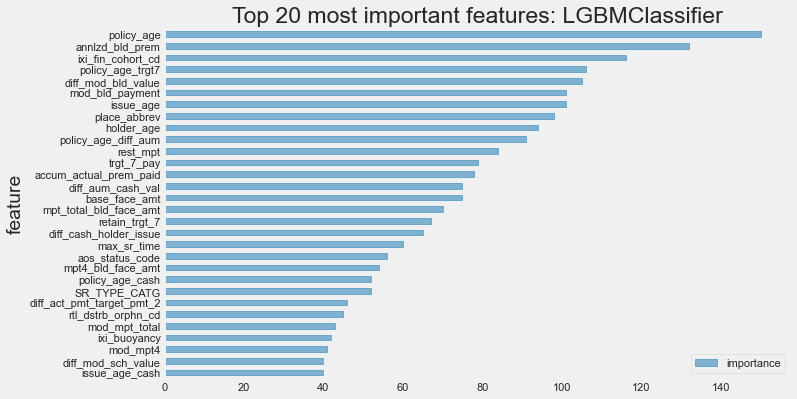

In [65]:
fn_importance_features(clf)

### in-sample fit

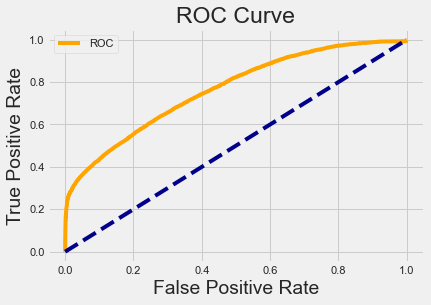

ROC value of:76.36
Accuracy:99.75
F1 score:10.96
Recall:6.52
Precision:34.50

 clasification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   3454789
           1       0.34      0.07      0.11      8042

    accuracy                           1.00   3462831
   macro avg       0.67      0.53      0.55   3462831
weighted avg       1.00      1.00      1.00   3462831



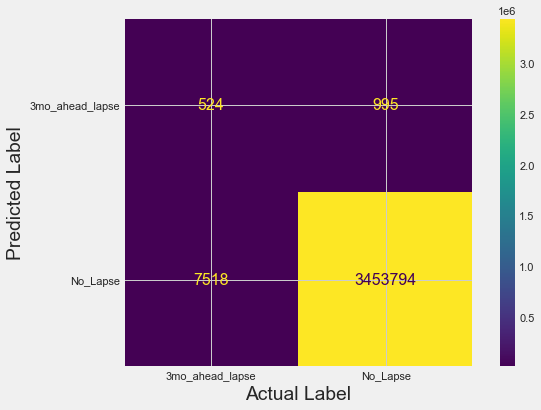

In [66]:
#### In-sample metrics
pred_Y_in = clf.predict(train_X)
pred_Y_prob_in = clf.predict_proba(train_X)[:,1]
tuned_lgb_prob_in = [train_Y, pred_Y_prob_in]
fn_metrics(train_Y, pred_Y_prob_in, pred_Y_in)

In [79]:
# # ## in-sample results 
# df_in_predict = pd.DataFrame({'prob': pred_Y_prob_in, 'predict': pred_Y_in}, columns=['prob', 'predict'], index = train_X.index.copy())

# # # Build scored dataset
# results_in = df.join(df_in_predict, how='right')

MemoryError: Unable to allocate 2.73 GiB for an array with shape (106, 3462831) and data type object

### out-of-sample fit

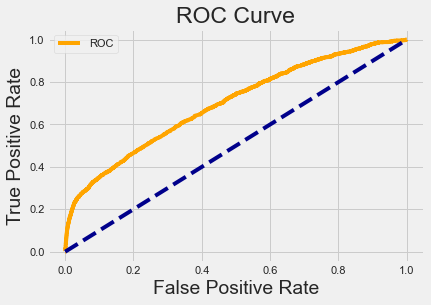

ROC value of:69.72
Accuracy:99.70
F1 score:2.16
Recall:1.38
Precision:4.95

 clasification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    728241
           1       0.05      0.01      0.02      1742

    accuracy                           1.00    729983
   macro avg       0.52      0.51      0.51    729983
weighted avg       1.00      1.00      1.00    729983



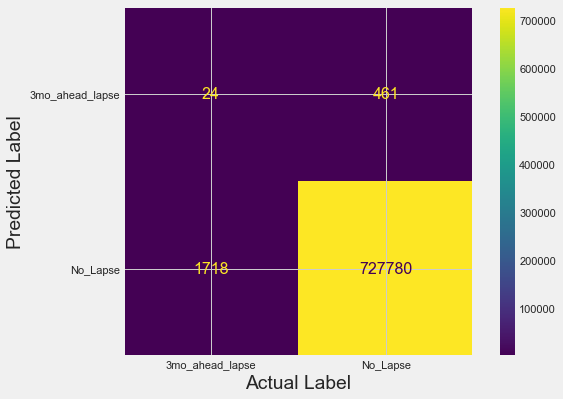

In [67]:
#Out-of-sample metrics 
pred_Y_out = clf.predict(test_X)
pred_Y_prob_out = clf.predict_proba(test_X)[:,1]
tuned_lgb_prob_out = [test_Y, pred_Y_prob_out]

#print out ROC curve, metrics, and confuction matrix
fn_metrics(test_Y, pred_Y_prob_out, pred_Y_out)

In [96]:
## out-of-sample results 
df_out_predict = pd.DataFrame({'prob': pred_Y_prob_out, 'predict': pred_Y_out}, columns=['prob', 'predict'], index = test_X.index.copy())

# Build scored dataset
score = ml_dataset.join(df_out_predict, how='right')
#results_out = results_out.sort_index()

In [82]:
# sample = results_out[results_out['agmt_pkge_id']  =='R31350050000']
# sample.to_csv('sample.csv')

In [97]:
score.to_parquet('results_out.parquet')

### decile

In [117]:
# rank_method = 'prob'
def decile_table(rank_method):
    ser, bins = pd.qcut(score[rank_method], 10, retbins=True, labels=False,duplicates='drop')
    bins[10]=1
    
    score['prob_rank']= pd.cut(score[rank_method], bins=bins, labels=False,include_lowest=True)
    
    col         = 'prob_rank'
    conditions  = [(score[col] >=0) & (score[col] < 1), (score[col] >=1) & (score[col] < 2) , (score[col] >=2) & (score[col] < 3),
                (score[col] >=3) & (score[col] < 4) ,  (score[col] >=4) & (score[col] < 5) ,  (score[col] >=5) & (score[col] < 6) ,
                 (score[col] >=6) & (score[col] < 7) ,  (score[col] >=7) & (score[col] < 8) ,  (score[col] >=8) & (score[col] < 9),
                 (score[col] >=9) & (score[col] < 10) , (score[col] >= 10)]

    choices     = [ 'D1','D2','D3','D4','D5','D6','D7','D8','D9','D10','NoScore' ]
    
     # events and non-events
    nonevents = score[score['3mo_ahead_Lapse']==0]
    events = score[score['3mo_ahead_Lapse']==1]

    # bins calculation
    bins =  pd.DataFrame(bins*100).T
    bins_table = bins_table.append(bins)

    #crate a pivot table that counts number of non-events
    g = pd.pivot_table(nonevents, values='policy_id', aggfunc = "count", index=['3mo_ahead_Lapse'], columns=[decile_method])
    b = pd.pivot_table(events, values='policy_id', aggfunc = "count", index=['3mo_ahead_Lapse'], columns=[decile_method])

    #append data to get Good and Bad counts
    good = good.append(g)
    good =good.reindex(['D1','D2','D3','D4','D5','D6','D7','D8','D9','D10', 'NoScore'], axis=1)

    bad = bad.append(b)
    bad =bad.reindex(['D1','D2','D3','D4','D5','D6','D7','D8','D9','D10', 'NoScore'], axis=1)
    
    #decile table 
    d_table = bad/(good+bad)*100
    d_table = d_table.reindex(['D1','D2','D3','D4','D5','D6','D7','D8','D9','D10', 'NoScore'], axis=1)
    d_table = d_table.round(2)
    d_table=  d_table.rename_axis('3mo_ahead_Lapse')
    
    return d_table

In [118]:
decile_table('prob')

MemoryError: Unable to allocate 574. MiB for an array with shape (103, 729983) and data type float64

In [98]:
ser, bins = pd.qcut(score['prob'], 10, retbins=True, labels=False,duplicates='drop')
bins[10]=1



In [99]:
score['prob_rank']= pd.cut(score['prob'], bins=bins, labels=False,include_lowest=True)

In [106]:
col         = 'prob_rank'
conditions  = [(score_day[col] >=0) & (score_day[col] < 1), (score_day[col] >=1) & (score_day[col] < 2) , (score_day[col] >=2) & (score_day[col] < 3),
                       (score_day[col] >=3) & (score_day[col] < 4) ,  (score_day[col] >=4) & (score_day[col] < 5) ,  (score_day[col] >=5) & (score_day[col] < 6) ,
                       (score_day[col] >=6) & (score_day[col] < 7) ,  (score_day[col] >=7) & (score_day[col] < 8) ,  (score_day[col] >=8) & (score_day[col] < 9),
                       (score_day[col] >=9) & (score_day[col] < 10) , (score_day[col] >= 10)]
choices     = [ 'D1','D2','D3','D4','D5','D6','D7','D8','D9','D10','NoScore' ]

,month,agmt_pkge_id,aos_status_code,val_inforce_cls,kind_code,sub_kind,conv_undrwrt_code,conv_type,spec_id,premium_basis,...,policy_age_sq,holder_age_cash,policy_age_cash,issue_age_cash,diff_cash_holder_issue,policy_age_trgt7,policy_age_diff_aum,prob,predict,prob_rank
3645086,6,987718480000,B,PP,01481,B,None,None,307,2,...,123904,1705083.0,8958048.0,967062.0,738021.0,0.0,15379112.32,0.005899,0,9
3645087,6,978451400000,B,PP,01469,B,None,None,269,2,...,122500,1303260.0,7602350.0,673351.0,629909.0,0.0,3662389.50,0.002204,0,7
3645088,6,V11056490000,A,PP,CVL01,A,None,None,14301,1,...,62001,28735050.0,103696050.0,20406050.0,8329000.0,15574950.0,590819.73,0.000812,0,2
3645089,6,946307420000,B,PP,01481,B,None,None,307,2,...,102400,1022912.0,5114560.0,607354.0,415558.0,0.0,-36886.40,0.002971,0,9
3645090,6,966248100000,B,PP,01481,B,None,None,307,2,...,102400,1835712.0,8158720.0,1172816.0,662896.0,0.0,307993.60,0.002257,0,7


In [ ]:
ser, bins = pd.qcut(score_day[score_method], 10, retbins=True, labels=False,duplicates='drop')
bins[10]=1   #increase max of bin 10 probability to 1

score_day[rank_method]= pd.cut(score_day[score_method], bins=bins, labels=False,include_lowest=True)
score_day[rank_method]= score_day[rank_method].fillna(10)

        # Assign decile names (D1, D2, etc.) based on pre-determeind rank on 1st day
        col         = rank_method
        conditions  = [(score_day[col] >=0) & (score_day[col] < 1), (score_day[col] >=1) & (score_day[col] < 2) , (score_day[col] >=2) & (score_day[col] < 3),
                       (score_day[col] >=3) & (score_day[col] < 4) ,  (score_day[col] >=4) & (score_day[col] < 5) ,  (score_day[col] >=5) & (score_day[col] < 6) ,
                       (score_day[col] >=6) & (score_day[col] < 7) ,  (score_day[col] >=7) & (score_day[col] < 8) ,  (score_day[col] >=8) & (score_day[col] < 9),
                       (score_day[col] >=9) & (score_day[col] < 10) , (score_day[col] >= 10)]
        choices     = [ 'D1','D2','D3','D4','D5','D6','D7','D8','D9','D10','NoScore' ]

        score_day[decile_method] = np.select(conditions, choices, default= 'NoScore')

        # events and non-events
        nonevents = score_day[score_day['3mo_ahead_Lapse']==0]
        events = score_day[score_day['3mo_ahead_Lapse']==1]

        # bins calculation
        bins =  pd.DataFrame(bins*100).T
        bins_table = bins_table.append(bins)

        #crate a pivot table that counts number of non-events
        g = pd.pivot_table(nonevents, values='loanid', aggfunc = "count", index=['3mo_ahead_Lapse'], columns=[decile_method])
        b = pd.pivot_table(events, values='loanid', aggfunc = "count", index=['3mo_ahead_Lapse'], columns=[decile_method])

        #append data to get Good and Bad counts
        good = good.append(g)
        good =good.reindex(['D1','D2','D3','D4','D5','D6','D7','D8','D9','D10', 'NoScore'], axis=1)

        bad = bad.append(b)
        bad =bad.reindex(['D1','D2','D3','D4','D5','D6','D7','D8','D9','D10', 'NoScore'], axis=1)


    #decile table 
    d_table = bad/(good+bad)*100
    d_table = d_table.reindex(['D1','D2','D3','D4','D5','D6','D7','D8','D9','D10', 'NoScore'], axis=1)
    d_table = d_table.round(2)
    d_table=  d_table.rename_axis('PastDue')

In [34]:

def decile_table_pred (score_method,rank_method, decile_method, rollback): 
    pd.options.display.float_format = '{:,.2f}'.format
    good = pd.DataFrame([])
    bad = pd.DataFrame([])
    bins_table = pd.DataFrame([])
    for i in score['PastDue'].unique():
        score_day = score[score['PastDue']==i]
        ser, bins = pd.qcut(score_day[score_method], 10, retbins=True, labels=False,duplicates='drop')
        bins[10]=1   #increase max of bin 10 probability to 1

        score_day[rank_method]= pd.cut(score_day[score_method], bins=bins, labels=False,include_lowest=True)
        score_day[rank_method]= score_day[rank_method].fillna(10)

        # Assign decile names (D1, D2, etc.) based on pre-determeind rank on 1st day
        col         = rank_method
        conditions  = [(score_day[col] >=0) & (score_day[col] < 1), (score_day[col] >=1) & (score_day[col] < 2) , (score_day[col] >=2) & (score_day[col] < 3),
                       (score_day[col] >=3) & (score_day[col] < 4) ,  (score_day[col] >=4) & (score_day[col] < 5) ,  (score_day[col] >=5) & (score_day[col] < 6) ,
                       (score_day[col] >=6) & (score_day[col] < 7) ,  (score_day[col] >=7) & (score_day[col] < 8) ,  (score_day[col] >=8) & (score_day[col] < 9),
                       (score_day[col] >=9) & (score_day[col] < 10) , (score_day[col] >= 10)]
        choices     = [ 'D1','D2','D3','D4','D5','D6','D7','D8','D9','D10','NoScore' ]

        score_day[decile_method] = np.select(conditions, choices, default= 'NoScore')

        # events and non-events
        nonevents = score_day[score_day['3mo_ahead_Lapse']==0]
        events = score_day[score_day['3mo_ahead_Lapse']==1]

        # bins calculation
        bins =  pd.DataFrame(bins*100).T
        bins_table = bins_table.append(bins)

        #crate a pivot table that counts number of non-events
        g = pd.pivot_table(nonevents, values='loanid', aggfunc = "count", index=['3mo_ahead_Lapse'], columns=[decile_method])
        b = pd.pivot_table(events, values='loanid', aggfunc = "count", index=['3mo_ahead_Lapse'], columns=[decile_method])

        #append data to get Good and Bad counts
        good = good.append(g)
        good =good.reindex(['D1','D2','D3','D4','D5','D6','D7','D8','D9','D10', 'NoScore'], axis=1)

        bad = bad.append(b)
        bad =bad.reindex(['D1','D2','D3','D4','D5','D6','D7','D8','D9','D10', 'NoScore'], axis=1)


    #decile table 
    d_table = bad/(good+bad)*100
    d_table = d_table.reindex(['D1','D2','D3','D4','D5','D6','D7','D8','D9','D10', 'NoScore'], axis=1)
    d_table = d_table.round(2)
    d_table=  d_table.rename_axis('PastDue')
    
    return good, bad, bins_table, d_table

